In [3]:
import tensorflow as tf
import os 
import time
import glob
import matplotlib.pyplot as plt
import PIL
from IPython import display
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import numpy as np
from tensorflow.keras import backend as K
from PIL import Image
import pickle
from pathlib import Path
import cv2

In [4]:
# データトリミング*700
raw_filename = os.listdir('raw')

y0 = 160
y1 = 960
x0 = 0
x1 = 1200

for name in raw_filename:
    path = Path('raw',name)
    save_path = Path('resized/1200_800',name)
    image = Image.open(path)
    img = np.asarray(image)
    img = img[y0: y1, x0: x1]
    color_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite(str(save_path), color_img)

In [5]:
# トリミング64*64

filenames = os.listdir('raw')
y0 = 0
y1 = 64
x0 = 0
x1 = 64

for name in filenames:
    fl = 'resized/64_64/'+name[:14]
    os.makedirs(fl)
    path = Path('resized/1200_800',name)
    num = 0
    image = Image.open(path)
    img = np.asarray(image)
    for i in range(12):
        for j in range(18):
            save_path = Path(fl,str(num)+'.jpg')
            x_0 = x0 + j*64
            x_1 = x1 + j*64
            y_0 = y0 + i*64
            y_1 = y1 + i*64
            crop_img = img[y_0: y_1, x_0: x_1]
            color_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
            cv2.imwrite(str(save_path), color_img)
            num +=1


In [6]:
# トリミング64*64 step幅30

filenames = os.listdir('raw')
y0 = 0
y1 = 64
x0 = 0
x1 = 64

for name in filenames:
    fl = 'resized/64_64_30/'+name[:14]
    os.makedirs(fl)
    path = Path('resized/1200_800',name)
    num = 0
    image = Image.open(path)
    img = np.asarray(image)
    for i in range(24):
        for j in range(37):
            save_path = Path(fl,str(num)+'.jpg')
            x_0 = x0 + j*30
            x_1 = x1 + j*30
            y_0 = y0 + i*30
            y_1 = y1 + i*30
            crop_img = img[y_0: y_1, x_0: x_1]
            color_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
            cv2.imwrite(str(save_path), color_img)
            num +=1


In [262]:
train_path_0 ='dataset/1210'

train_path_list_0 = []
for i,j,k in os.walk(train_path_0):
    for filename in k:
        if os.path.splitext(filename)[1] == ".jpg":
            x = os.path.join(i,filename)
            train_path_list_0.append(x)



train_datas_0 = []
for i in range(len(train_path_list_0)):
    data_path = train_path_list_0[i]
    img = Image.open(data_path)
    array = np.asarray(img)
    array = tf.reshape(array,[64, 64, 3])
    train_datas_0.append(array)
train_label_0 = np.zeros(len(train_path_list_0),dtype=np.uint8)
tensor_train_0 = tf.stack(train_datas_0,axis=0)



datas_train = tensor_train_0



In [263]:
train_images =tf.cast(datas_train,tf.float32)
train_images = (train_images - 127.5) / 127.5 
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(len(train_images)).batch(10)

In [264]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 1024)))
    # assert model.output_shape == (None, 128, 128, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    # assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    # assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    # assert model.output_shape == (None, 28, 28, 1)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    # assert model.output_shape == (None, 28, 28, 1)

    return model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


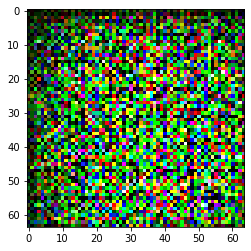

In [265]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
img = generated_image[ 0,:, :, :]*255
plt.imshow(img[:,:,:])

In [266]:
generator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_4 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 8, 8, 512)         13107200  
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 512)         2048      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 8, 8, 512)        

In [267]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [268]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 256)        

In [269]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00024349]], shape=(1, 1), dtype=float32)


In [270]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [271]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [272]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [273]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4,beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4,beta_1=0.5)

In [274]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [275]:
EPOCHS = 30
noise_dim = 100
num_examples_to_generate = 4

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [276]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([50, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [277]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [278]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8, 8))

  for i in range(predictions.shape[0]):
      plt.subplot(2, 2, i+1)
      a =predictions[i, :, :, :]* 127.5 + 127.5
      a = np.asarray(a,dtype=np.uint8)
      img = Image.fromarray(a)
      plt.imshow(img)
      plt.axis('off')

  plt.savefig('./graf/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

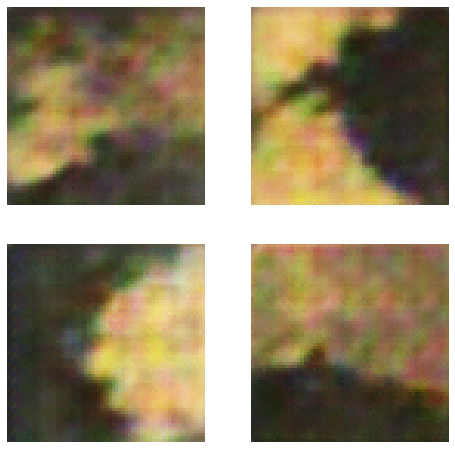

In [280]:
train(train_dataset, 100)

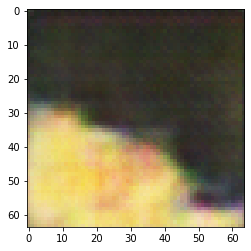

In [282]:
import cv2
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image = generated_image[0, :, :, :]* 127.5 + 127.5

generated_image = np.asarray(generated_image,dtype=np.uint8)
img = Image.fromarray(generated_image)
plt.imshow(img)

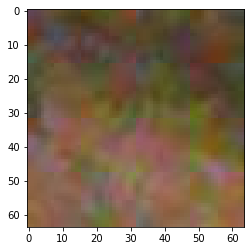

In [261]:
import random
test_image = train_images[random.randint(0,200)]
test_image = test_image* 127.5 + 127.5
test_image = np.asarray(test_image,dtype=np.uint8)
test_img = Image.fromarray(test_image)
plt.imshow(test_img)

In [286]:
generator.save('model/dcgan_1210.h5')

In [231]:
model = tf.keras.models.load_model('model/1209/dcgan.h5')

In [285]:
for i in range(500):
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)
    generated_image = generated_image[0, :, :, :]* 127.5 + 127.5

    generated_image = np.asarray(generated_image,dtype=np.uint8)
    img = Image.fromarray(generated_image)
    img.save('output/1210/'+str(i)+'.jpg')


In [287]:
for i in range(500):
    noise = tf.random.normal([1, 100])
    generated_image = model(noise, training=False)
    generated_image = generated_image[0, :, :, :]* 127.5 + 127.5

    generated_image = np.asarray(generated_image,dtype=np.uint8)
    img = Image.fromarray(generated_image)
    img.save('output/1209/'+str(i)+'.jpg')
